# SWiFT Template
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

## Preamble
Set file paths, enter physical constants, import modules, etc...

In [1]:
import glob
import os

### File paths and file names

In [2]:
# File paths, customize to your own directory tree
#case_id = 'SA_DX12_DZ4_256X256_WD286_PBLH1000'
case_id = 'SA_DX12_DZ4_481X481_WD286_PBLH1000'

simulation_project_dir = '/p/lscratchh/mirocha2/SWiFT/2022/NEUTRAL/'
simulation_dir = simulation_project_dir + case_id + '/'
pdata_dir = '/p/lustre3/lassman1/A2E_MMC/SWiFT/process_data/'

pdata_loc = pdata_dir + case_id + '/'
#pdata_loc = pdata_dir + 'example_routine' + '/'

fname_stem = 'wrfout_d01*'

In [3]:
if os.path.exists( pdata_loc):
    print("pdata directory exists")
else:
    print("making directory " + pdata_loc)
    os.mkdir( pdata_loc )
    

pdata directory exists


In [4]:
# pdata save filenames
pdata_3D = 'pdata_3d.nc'
pdata_spectra = 'pdata_spectra.nc'



In [5]:
NF = 48


flist = glob.glob( simulation_dir + fname_stem )
flist.sort()

flist = flist[-12:]

### Import modules

In [6]:
# Well-known python modules (i.e, available through conda)
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import sys


In [7]:
# Less well-known

import wrf # as wrf

module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)
import mmctools

### Physical constants and other parameters

In [8]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [9]:
########################
# Postprocess WRF output
########################
#
#
#    The purpose of this function is to take the DataSet that is produced from an xarray 'open_mfdataset'
#         function call and to modify it to work well with mmctools functions. This includes:
#               -Renaming dimensions and coordinates to code standards
#               -Computing 1-D Z [m] variable and assigning it as a coordinate
#               -Destaggering winds
#               -Returns only the requested variables (optional)
#               -Truncates the simulation output at some height (optional)

def postprocess_wrf_outout( ds, variable_list = ['U', 'V', 'W', 'T', 'UST'], z_max = None ):
    '''
    Changes coordinate, dimension, and variable names, computes z, destaggers wind fields.
        ds: Xarray Dataset. Default from open_mfdataset on all WRF variables
        
        variable_list: Array-liike. Contains variable names (strings) to be extracted from the WRF output. Default is U, V, W, and T
            (wind components and potential temperature)
            
        z_max: maximum z (float). If defined, any model output above this height will be truncated. Default is None.
    '''
    
    # Rename dims, and drop XLAT/XLONG coords (since they're all 0 for an idealized run)
    print("Renaming dims...")
    ds = ds.rename_dims( {'west_east': 'nx', 'south_north': 'ny', 'bottom_top': 'nz',
                'west_east_stag': 'nx_stag', 'south_north_stag': 'ny_stag', 'bottom_top_stag': 'nz_stag'})

    ds = ds.drop(['XLAT','XLONG','XLAT_U','XLONG_U','XLAT_V','XLONG_V'])
    
    # Compute x, y, and z. Assign as coords.
    print("Computing x, and y...")
    ds['x'] = ds.nx * ds.DX
    ds['y'] = ds.ny * ds.DY

    print('...and now z...')

    ds['z_stag_4D'] = ( ds.PH + ds.PHB) / g
    ds['z_stag_1D'] = ds.z_stag_4D.mean(dim = ('nx', 'ny', 'Time') )
    z1D = (ds.z_stag_1D.values[:-1] + \
           ds.z_stag_1D.values[1:] ) / 2.
    ds['z1D'] = xr.DataArray( z1D, dims = 'nz' )

    print("Assigning coords...")
    ds  =  ds.assign_coords({'x': ds.x, 'y': ds.y, 'z': ds.z1D})
    
    # Truncate above z_max
    if z_max is not None:
        print(f"z_max is defined, truncating above {z_max} m")
        z_ind = np.where( ds.z1D > z_max )
        #print(z_ind)
        if len(z_ind) == 0:
            print(f"z_max = {z_max} is higher than model top")
            print("continuing")
        else:
            z_ind = z_ind[0][0]
            #print(z_ind)
            ds = ds.isel(nz = slice(0,z_ind + 1), nz_stag =slice(0,z_ind + 2) )
            print(f"Grid cells above {z_max} discarded")
    
    else:
        print("z_max is none, processing entire domain")
        
    print("destaggering winds...")
    ds = ds.rename({'U': 'U_stag', 'V': 'V_stag', 'W': 'W_stag'})
    print('...U...')
    ds['U'] = wrf.destagger( ds.U_stag, stagger_dim = 3, meta = True)
    print('...V...')
    ds['V'] = wrf.destagger( ds.V_stag, stagger_dim = 2, meta = True)
    print('...and now W...')
    ds['W'] = wrf.destagger( ds.W_stag, stagger_dim = 1, meta = True)
    
    # Grab only variables of interest
    if variable_list is not None:
        print("variables_list is defined, grabbing only these variables")
        data_variables = {}
        for v in variable_list:
            data_variables[v] = ds[v]
        ds = xr.Dataset( data_vars = data_variables, coords = ds.coords)
    else:
        print("Including all variables")
    
    return ds


    

In [10]:
########################
# calc_mean_pert
########################
# Calculate bar and prime (mean and perturbation) quantities
#

def calc_mean_pert( ds, variable_list = ['U', 'V', 'W'], mean_wind_dir = 'periodic',  ):
    '''
    Purpose of this function is to compute the mean and perturbation quantities for computing fluxes and stresses.
    
        ds: xarray Dataset. Contains the coords, dims, and variables (U,V,W) 
            that have been computed by the postprocessing function above
        variable_list: array-like. Contains variable names (strings) for mean/perturbation quantities.
            Must be 4-D variables using x/y/z coords, error-catches are not implemented.
        mean_wind_dir: either 'periodic' (default) or 'zonal' (i.e. mean wind dir is from west to east).
            periodic: compute means on x/y planes to get mean quantities as a function of time and height
            zonal: mean quantities will be computed on lines of constant x, so mean will also be a function of x.
                this means less statistical power, and some temporal averaging may be required, but that is not
                accounted for in this function (yet)
    '''
    
    mean_str_suff = '_bar'
    pert_str_suff = '_p'
    
    for vv in variable_list:
        print(vv)
        mean_str = vv + mean_str_suff
        pert_str = vv + pert_str_suff
        
        if mean_wind_dir == 'periodic':
            print("Periodic simulation")
            ds[mean_str] = ds[vv].mean(dim = ('nx', 'ny'))
            ds[pert_str] = ds[vv] - ds[mean_str]
        elif mean_wind_dir == 'zonal':
            print("Zonal simulation, may need some temporal averaging for power")
            ds[mean_str] = ds[vv].mean(dim = ('nx'))
            ds[pert_str] = ds[vv] - ds[mean_str]
    return ds
    

In [11]:
########################
# calc_stresses
########################
# Calculate stress terms
#

def calc_stresses( ds, do_uw = True, do_vw = False, do_uv = False):
    '''
    Calculate components of the Stress-Energy tensor relevant to shear production of turbulence
        ds: xarray dataset.
        do_uw: Boolean (default True). If true, calculates tau13 (the u'w' component of the stress energy tensor)
        do_vw: Boolean (default False). If true, calculates tau23 (the u'w' component of the stress energy tensor)
        do_uv: Boolean (default False). If true, calculates tau12 (the u'w' component of the stress energy tensor)
    '''
    if do_uw:
        print('calculating tau13...')
        ds['tau13'] = ( ds.U_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_vw:
        print('calculating tau23...')
        ds['tau23'] = ( ds.V_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_uv:
        print('calculating tau12...')
        ds['tau12'] = ( ds.U_p * ds.V_p ).mean(dim = ('nx', 'ny'))
        
    return ds
    

In [12]:
########################
# calc_tke
########################
# Calculate resolved TKE
#

def calc_tke( ds ):
    '''
    Calculates RESOLVE LES TKE. Does not compute the subgrid component.
        ds: xarray dataset.
    '''
    print("calculating TKE...")
    ds['TKE'] = 1./2. * (  ( ds.U_p * ds.U_p ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.V_p * ds.V_p ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.W_p * ds.W_p ).mean(dim = ('nx', 'ny') ) )
    
    return ds

## Actual analysis begins

### Load 4-D model output

In [13]:
# Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

save_pdata = True

if os.path.exists(pdata_loc + pdata_3D):
    print("Process data exists")
    ds = xr.open_dataset( pdata_loc + pdata_3D )
else:
    print("Process data does not exist, reading from WRFOUT")
    ds = xr.open_mfdataset( flist, \
                           parallel = True, \
                           chunks = {'Time':24},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_outout( ds, z_max = 1100 \
                              , variable_list = ['U', 'V', 'W', 'T','m13', 'mh3', 'TKE'] \
                               ) #No subgrid stress/TKE components
    #sys.exit()
    try:
        ds = ds.rename({'TKE': 'TKE_SGS'})
        print('Renaming wrfout variable "TKE" to "TKE_SGS" since this is the subgridscale TKE')
    except:
        print('Unable to rename TKE to TKE_SGS, variable may be missing')
    try:
        ds = ds.rename({'m13': 'tau13_SGS'})
        print('Renaming wrfout variable "m13" to "tau13_SGS" to be consistent with resolved stress')
    except:
        print('Unable to rename TKE to TKE_SGS, variable may be missing')        
    ds = calc_mean_pert( ds, variable_list = ['U', 'V', 'W', 'T'] )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving pdata...")
        ds.to_netcdf(pdata_loc + pdata_3D)
    

#sys.exit()

Process data exists


/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


# Compute Spectra

In [15]:
save_spectra_pdata = True


if os.path.exists(pdata_loc + pdata_spectra):
    print("Spectra process data exists")
    psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
else:
    from mmctools.helper_functions import calc_spectra
    
    print("Spectra process data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 10, 20, 40] \
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))
    
    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})
    
    psd_ds['z'] = xr.DataArray( ds.z[[5, 10, 20, 40]].values, dims = 'nz' )
    
    if save_spectra_pdata:
        print("Saving spectra process data")
        psd_ds.to_netcdf( pdata_loc + pdata_spectra )
    

Spectra process data exists


/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [16]:
ds = ds.swap_dims({'Time': 'XTIME'})



/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [17]:
ds_1hr = ds.resample({'XTIME':'1H'}).mean()

In [18]:
psd_ds = psd_ds.swap_dims({'Time': 'XTIME'})

/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [19]:
psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()

In [20]:
NT_hr = len( ds_1hr.XTIME )

In [29]:
ds_1hr

<xarray.Dataset>
Dimensions:    (XTIME: 12, nx: 480, ny: 480, nz: 66)
Coordinates:
  * XTIME      (XTIME) object 0001-01-02 21:00:00 ... 0001-01-03 08:00:00
    x          (nx) float64 0.0 12.0 24.0 36.0 ... 5.724e+03 5.736e+03 5.748e+03
    z          (nz) float32 2.0543776 6.2715173 ... 1078.2097 1102.0605
    y          (ny) float64 0.0 12.0 24.0 36.0 ... 5.724e+03 5.736e+03 5.748e+03
Dimensions without coordinates: nx, ny, nz
Data variables:
    U          (XTIME, nz, ny, nx) float32 2.8597286 2.8606584 ... 9.847342
    V          (XTIME, nz, ny, nx) float32 0.19879027 0.21877246 ... -2.5871053
    W          (XTIME, nz, ny, nx) float32 -0.0156002445 ... 0.029051617
    T          (XTIME, nz, ny, nx) float32 0.047683716 ... 0.56607056
    tau13_SGS  (XTIME, nz, ny, nx) float32 -0.14552255 ... 4.499426e-08
    mh3        (XTIME, nz, ny, nx) float32 -4.7066058e-07 ... -4.2795218e-08
    TKE_SGS    (XTIME, nz, ny, nx) float32 0.2867577 ... 7.0809836e-25
    U_bar      (XTIME, nz) float32 3.0285232 4.220371 ... 10.025714 9.754155
    U_p        (XTIME, nz, ny, nx) float32 -0.16879447 ... 0.09318638
    V_bar      (XTIME, nz) float32 0.06721425 0.082208075 ... -2.7356365
    V_p        (XTIME, nz, ny, nx) float32 0.13157602 0.1515582 ... 0.1485312
    W_bar      (XTIME, nz) float32 2.4876057e-08 7.385095e-08 ... 2.5264173e-06
    W_p        (XTIME, nz, ny, nx) float32 -0.015600268 ... 0.029049091
    T_bar      (XTIME, nz) float32 0.0477246 0.04772796 ... 0.63061273
    T_p        (XTIME, nz, ny, nx) float32 -4.088382e-05 ... -0.064542174
    tau13      (XTIME, nz) float32 -0.008698036 -0.0428844 ... -0.00039788763
    TKE        (XTIME, nz) float32 0.24224448 0.49981964 ... 0.013598245

# Some plots

In [21]:
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )

### Vertical profiles

Text(0, 0.5, 'Height [m]')

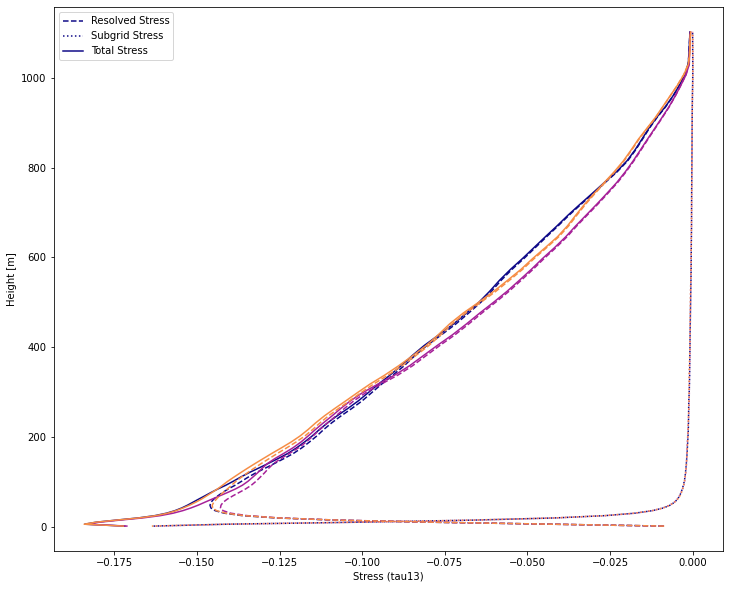

In [38]:
# Tau13 vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )

ct = 0
for tt in range(0, NT_hr)[::4]:
    ax.plot( ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , \
            c = time_colormap[tt], linestyle = '--', label = 'Resolved Stress' )
    ax.plot( ds_1hr.isel(XTIME = tt).tau13_SGS.mean(dim = ('nx', 'ny') ), ds_1hr.z , \
            c = time_colormap[tt], linestyle = ':', label = 'Subgrid Stress' )
    ax.plot( ds_1hr.isel(XTIME = tt).tau13_SGS.mean(dim = ('nx', 'ny') ) \
            + ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , \
            c = time_colormap[tt], label = 'Total Stress'  )
    if ct == 0:
        ax.legend(loc = 'best' )
    ct += 1
    
ax.set_xlabel('Stress (tau13)')
ax.set_ylabel('Height [m]')



(0.0, 200.0)

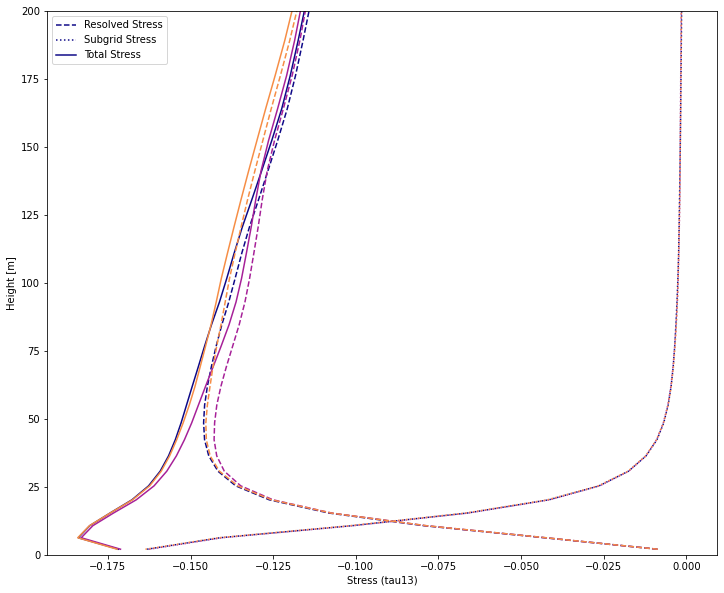

In [39]:
# Tau13 vertical profile, color a function of time
# Tau13 vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )

ct = 0
for tt in range(0, NT_hr)[::4]:
    ax.plot( ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , \
            c = time_colormap[tt], linestyle = '--', label = 'Resolved Stress' )
    ax.plot( ds_1hr.isel(XTIME = tt).tau13_SGS.mean(dim = ('nx', 'ny') ), ds_1hr.z , \
            c = time_colormap[tt], linestyle = ':', label = 'Subgrid Stress' )
    ax.plot( ds_1hr.isel(XTIME = tt).tau13_SGS.mean(dim = ('nx', 'ny') ) \
            + ds_1hr.isel(XTIME = tt).tau13, ds_1hr.z , \
            c = time_colormap[tt], label = 'Total Stress'  )
    if ct == 0:
        ax.legend(loc = 'best' )
    ct += 1
    
ax.set_xlabel('Stress (tau13)')
ax.set_ylabel('Height [m]')

ax.set_ylim([0.,200])

Text(0, 0.5, 'Height [m]')

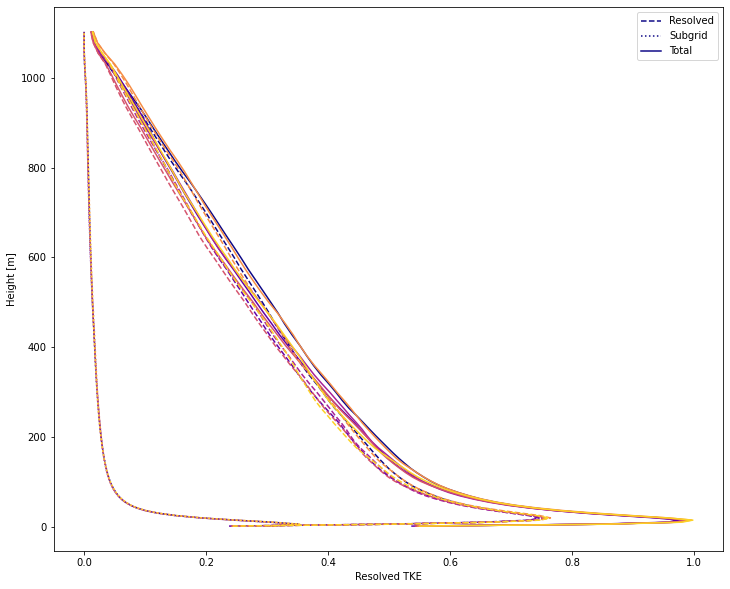

In [43]:
# TKE vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )

ct = 0
for tt in range(0, NT_hr)[::2]:
    ax.plot( ds_1hr.isel(XTIME = tt).TKE, ds_1hr.z , \
            c = time_colormap[tt], linestyle = '--', label = 'Resolved' )
    
    ax.plot( ds_1hr.isel(XTIME = tt).TKE_SGS.mean(dim = ('nx','ny')), ds_1hr.z , \
            c = time_colormap[tt], linestyle = ':', label = 'Subgrid' )
    
    ax.plot( ds_1hr.isel(XTIME = tt).TKE + \
            ds_1hr.isel(XTIME = tt).TKE_SGS.mean(dim = ('nx','ny')), ds_1hr.z , \
            c = time_colormap[tt],  label = 'Total' )
    
    if ct == 0:
        ax.legend(loc = 'best' )
    ct += 1
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')



(0.0, 200.0)

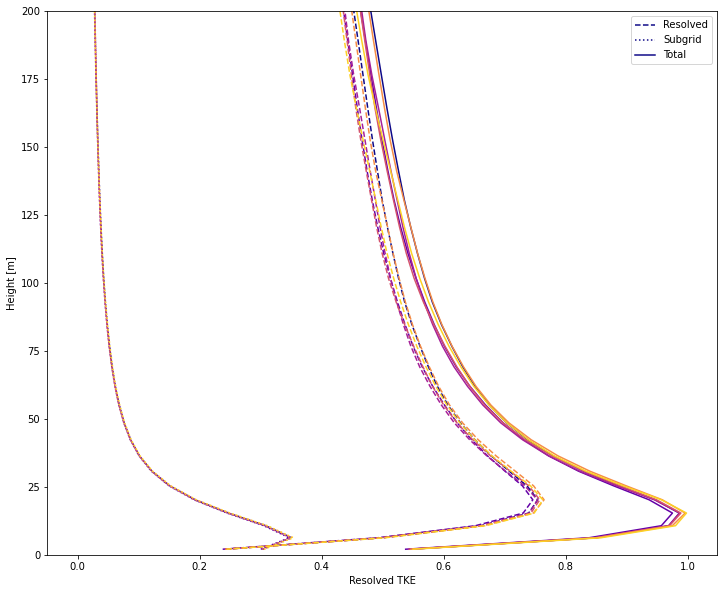

In [44]:
# TKE vertical profile, color a function of time
f, ax = plt.subplots( figsize = (12, 10) )

ct = 0
for tt in range(0, NT_hr)[::2]:
    ax.plot( ds_1hr.isel(XTIME = tt).TKE, ds_1hr.z , \
            c = time_colormap[tt], linestyle = '--', label = 'Resolved' )
    
    ax.plot( ds_1hr.isel(XTIME = tt).TKE_SGS.mean(dim = ('nx','ny')), ds_1hr.z , \
            c = time_colormap[tt], linestyle = ':', label = 'Subgrid' )
    
    ax.plot( ds_1hr.isel(XTIME = tt).TKE + \
            ds_1hr.isel(XTIME = tt).TKE_SGS.mean(dim = ('nx','ny')), ds_1hr.z , \
            c = time_colormap[tt],  label = 'Total' )
    
    if ct == 0:
        ax.legend(loc = 'best' )
    ct += 1
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.set_ylim([0., 200])

### Spectra

In [26]:
z_spectra = psd_ds_1hr.z.isel(XTIME = 0)
psd_ds_1hr['U_p_norm_power'] = psd_ds_1hr.U_p * psd_ds_1hr.frequency
psd_ds_1hr['W_p_norm_power'] = psd_ds_1hr.W_p * psd_ds_1hr.frequency

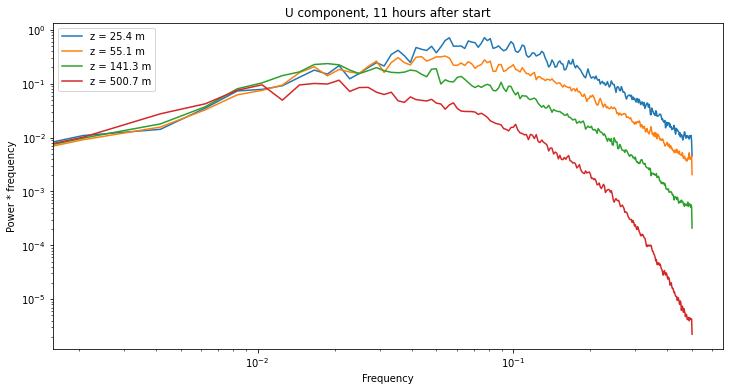

In [47]:
f, ax  = plt.subplots(figsize = ( 12, 6) )
tind = 11

for k in range(0,len(z_spectra)):
    ax.plot( psd_ds_1hr.frequency, psd_ds_1hr.U_p_norm_power.isel(XTIME = tind, nz = k),\
            label = f"z = {z_spectra.isel(nz=k).values:.1f} m" )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')


ax.set_title(f"U component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')


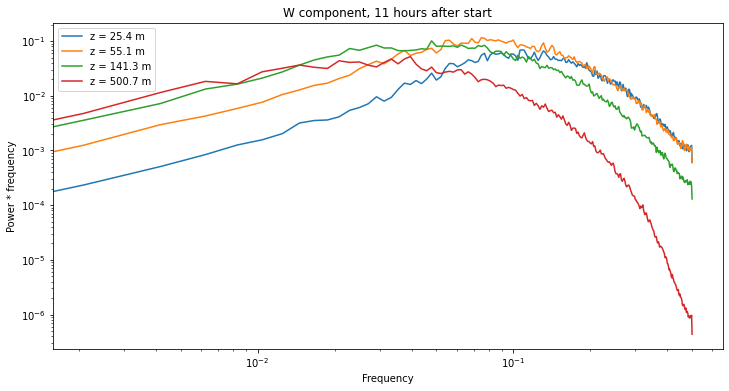

In [48]:
f, ax  = plt.subplots(figsize = ( 12, 6) )
tind = 11

for k in range(0,len(z_spectra)):
    ax.plot( psd_ds_1hr.frequency, psd_ds_1hr.W_p_norm_power.isel(XTIME = tind, nz = k),\
            label = f"z = {z_spectra.isel(nz=k).values:.1f} m" )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"W component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')


### Some examples for selecting values with xarray

In [49]:
# To view dataset
psd_ds_1hr

<xarray.Dataset>
Dimensions:         (XTIME: 12, frequency: 241, nz: 4)
Coordinates:
  * XTIME           (XTIME) object 0001-01-02 21:00:00 ... 0001-01-03 08:00:00
  * frequency       (frequency) float64 0.0 0.002083 0.004167 ... 0.4979 0.5
  * nz              (nz) int64 5 10 20 40
Data variables:
    U_p             (XTIME, nz, frequency) float32 1.0252185 ... 4.484546e-06
    W_p             (XTIME, nz, frequency) float32 0.020586269 ... 8.754506e-07
    z               (XTIME, nz) float32 25.363491 55.0997 ... 141.2839 500.73505
    U_p_norm_power  (XTIME, nz, frequency) float64 0.0 0.01382 ... 2.242e-06
    W_p_norm_power  (XTIME, nz, frequency) float64 0.0 0.0002718 ... 4.377e-07

In [50]:
# To view dimensions or coordinates

print(psd_ds_1hr.dims)
print('*************')
print(psd_ds_1hr.coords)

Frozen(SortedKeysDict({'XTIME': 12, 'frequency': 241, 'nz': 4}))
*************
Coordinates:
  * XTIME      (XTIME) object 0001-01-02 21:00:00 ... 0001-01-03 08:00:00
  * frequency  (frequency) float64 0.0 0.002083 0.004167 ... 0.4958 0.4979 0.5
  * nz         (nz) int64 5 10 20 40


In [51]:
# To access a variable
psd_ds_1hr.U_p

<xarray.DataArray 'U_p' (XTIME: 12, nz: 4, frequency: 241)>
array([[[1.02521849e+00, 6.63415003e+00, 8.53744411e+00, ...,
         2.03301776e-02, 2.06300095e-02, 1.04792565e-02],
        [9.91336167e-01, 6.66086578e+00, 9.68531799e+00, ...,
         9.90295690e-03, 9.45617724e-03, 4.77933884e-03],
        [1.14527786e+00, 6.55850601e+00, 9.49753952e+00, ...,
         1.01760391e-03, 9.75179486e-04, 4.93899803e-04],
        [8.28586578e-01, 8.22535038e+00, 1.35955534e+01, ...,
         1.04833134e-05, 1.05385398e-05, 5.41611143e-06]],

       [[1.33001196e+00, 9.42342472e+00, 1.04459219e+01, ...,
         2.28818636e-02, 2.15914473e-02, 9.91820823e-03],
        [1.62512290e+00, 1.11454802e+01, 1.16818275e+01, ...,
         1.04258284e-02, 1.02404216e-02, 5.06523391e-03],
        [1.88993847e+00, 1.17453194e+01, 1.13817835e+01, ...,
         1.11376354e-03, 1.04139524e-03, 5.17883629e-04],
        [1.16941667e+00, 9.21964931e+00, 8.50730419e+00, ...,
         6.30434079e-06, 6.19939829e-06, 3.18947787e-06]],

       [[1.14644861e+00, 6.11317396e+00, 6.25924063e+00, ...,
         2.07478665e-02, 2.11759061e-02, 1.06833354e-02],
...
        [6.58313751e-01, 5.10541296e+00, 7.91828299e+00, ...,
         9.74675640e-06, 9.91245270e-06, 4.70192890e-06]],

       [[8.54777634e-01, 4.70493603e+00, 7.16052246e+00, ...,
         1.98650621e-02, 2.07064766e-02, 1.10704200e-02],
        [9.16731656e-01, 5.52738571e+00, 8.30789852e+00, ...,
         1.01403138e-02, 1.02681657e-02, 4.79326909e-03],
        [8.18665028e-01, 6.74182081e+00, 9.86307621e+00, ...,
         1.06449798e-03, 1.00693561e-03, 5.04922529e-04],
        [6.71669424e-01, 5.11673164e+00, 5.85414886e+00, ...,
         9.30097667e-06, 9.46742421e-06, 4.86664430e-06]],

       [[1.22723830e+00, 5.22726011e+00, 3.40593314e+00, ...,
         2.20246632e-02, 1.69557054e-02, 9.13659763e-03],
        [1.29978704e+00, 4.37769127e+00, 3.74850512e+00, ...,
         8.55050981e-03, 8.95427074e-03, 4.10364242e-03],
        [9.99428391e-01, 4.69381094e+00, 4.28693485e+00, ...,
         1.13348255e-03, 1.03391043e-03, 4.17773699e-04],
        [6.03387117e-01, 4.87969732e+00, 6.60736370e+00, ...,
         8.52667472e-06, 8.62524485e-06, 4.48454603e-06]]], dtype=float32)
Coordinates:
  * XTIME      (XTIME) object 0001-01-02 21:00:00 ... 0001-01-03 08:00:00
  * frequency  (frequency) float64 0.0 0.002083 0.004167 ... 0.4958 0.4979 0.5
  * nz         (nz) int64 5 10 20 40

In [52]:
# To subset by some dimensions
psd_ds_1hr.U_p.isel( nz = 0, XTIME = slice(0, 10) )

<xarray.DataArray 'U_p' (XTIME: 10, frequency: 241)>
array([[1.02521849e+00, 6.63415003e+00, 8.53744411e+00, ...,
        2.03301776e-02, 2.06300095e-02, 1.04792565e-02],
       [1.33001196e+00, 9.42342472e+00, 1.04459219e+01, ...,
        2.28818636e-02, 2.15914473e-02, 9.91820823e-03],
       [1.14644861e+00, 6.11317396e+00, 6.25924063e+00, ...,
        2.07478665e-02, 2.11759061e-02, 1.06833354e-02],
       ...,
       [7.17396259e-01, 4.15704107e+00, 6.77839518e+00, ...,
        1.99161414e-02, 1.95011981e-02, 1.02852033e-02],
       [6.30912602e-01, 4.03139114e+00, 5.38537836e+00, ...,
        2.02937815e-02, 2.11653505e-02, 9.77995340e-03],
       [9.92085993e-01, 6.62342834e+00, 8.82260513e+00, ...,
        2.00800411e-02, 2.05686036e-02, 9.34179407e-03]], dtype=float32)
Coordinates:
  * XTIME      (XTIME) object 0001-01-02 21:00:00 ... 0001-01-03 06:00:00
  * frequency  (frequency) float64 0.0 0.002083 0.004167 ... 0.4958 0.4979 0.5
    nz         int64 5